# 1-D PV Clustering
[source](https://www.youtube.com/watch?v=xwZy3L1M9Is)

In [1]:
# imports
%matplotlib inline
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tslearn.datasets import CachedDatasets
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
plt.rcParams['figure.figsize'] = [25, 8]

warnings.filterwarnings('ignore', category=FutureWarning)

print(f'numpy version is : {np.__version__}')
print(f'pandas version is : {pd.__version__}')

numpy version is : 1.26.2
pandas version is : 2.1.4


## Project Settings For Reproduability

In [47]:
seed = 0
np.random.seed(seed)

## Load Data & Create Day Based Sequences

In [39]:
data = pd.read_excel('../Data/Data Set.xlsx', usecols=['Date', 'PV Power (kW)'])
data.index = data.Date
data.drop(['Date'], axis=1, inplace=True)
print(f'daa shape is : {data.shape}')

daa shape is : (17520, 1)


In [46]:
# Split Data based on date
df = data.copy()
result = [group[1] for group in df.groupby(df.index.date)]
X = np.array(result)
print(f'Data is : {X.shape}')

Data is : (365, 48, 1)


## Pre-Processing Dataset

In [50]:
scaler = TimeSeriesScalerMeanVariance()

X = scaler.fit_transform(X)
sz = X.shape[1]

## Plot Data

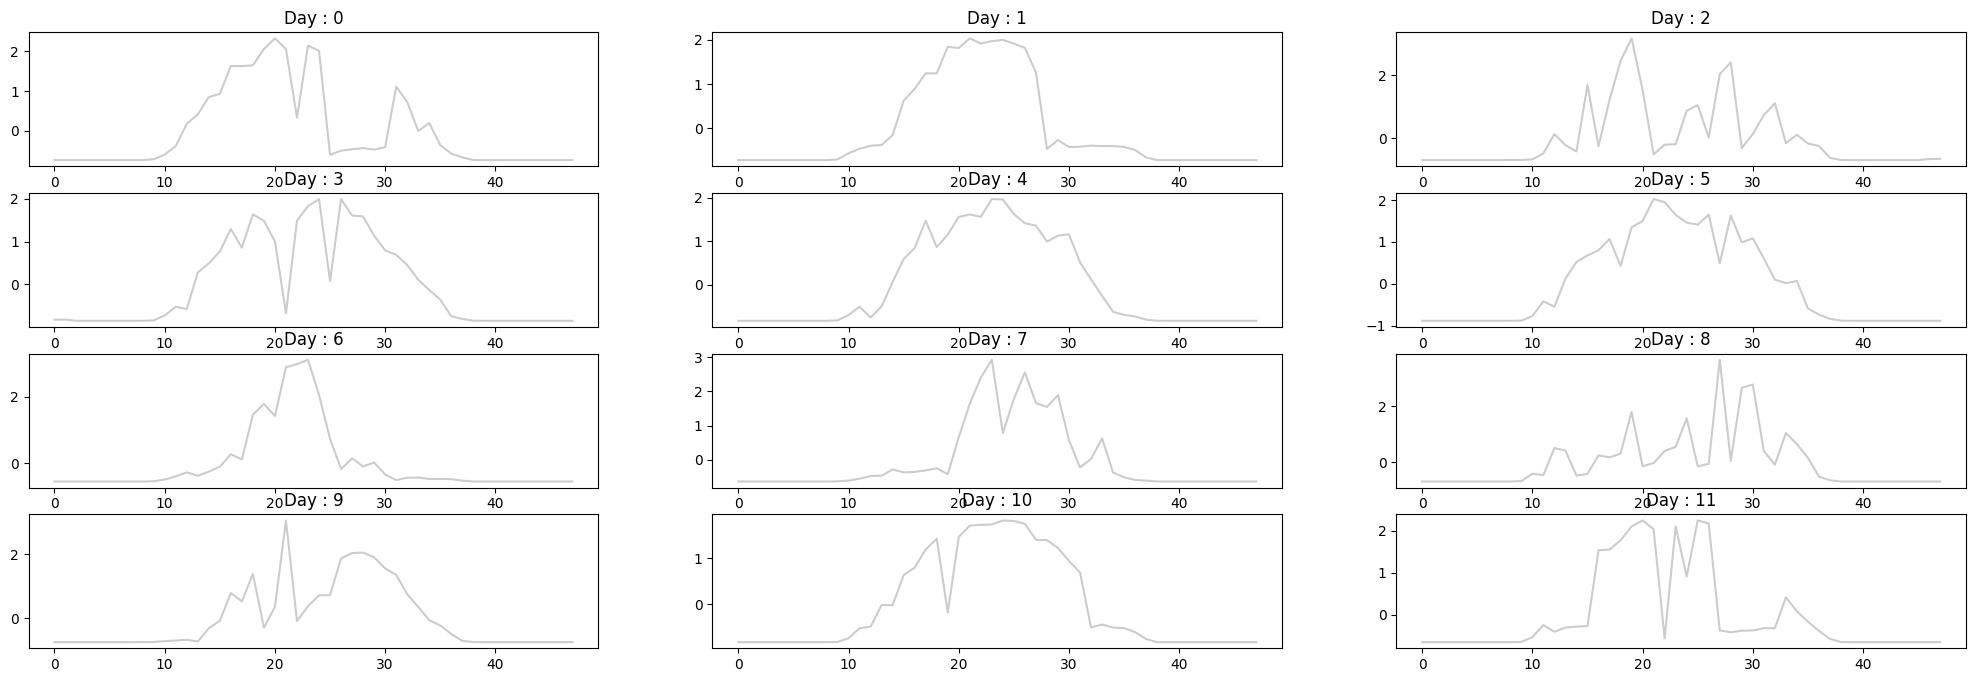

In [56]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(X[yi].ravel(), "k-", alpha=.2)
    plt.title(f'Day : {yi}')

## Number of Cluster Decission

### Using Inertia Method

In [57]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)

    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

In [58]:
Sum_of_squared_distances

[5.344022234862795,
 4.380317165901195,
 3.991152587157276,
 3.6029998968238623,
 3.3776354197938967,
 3.2993295142145356]

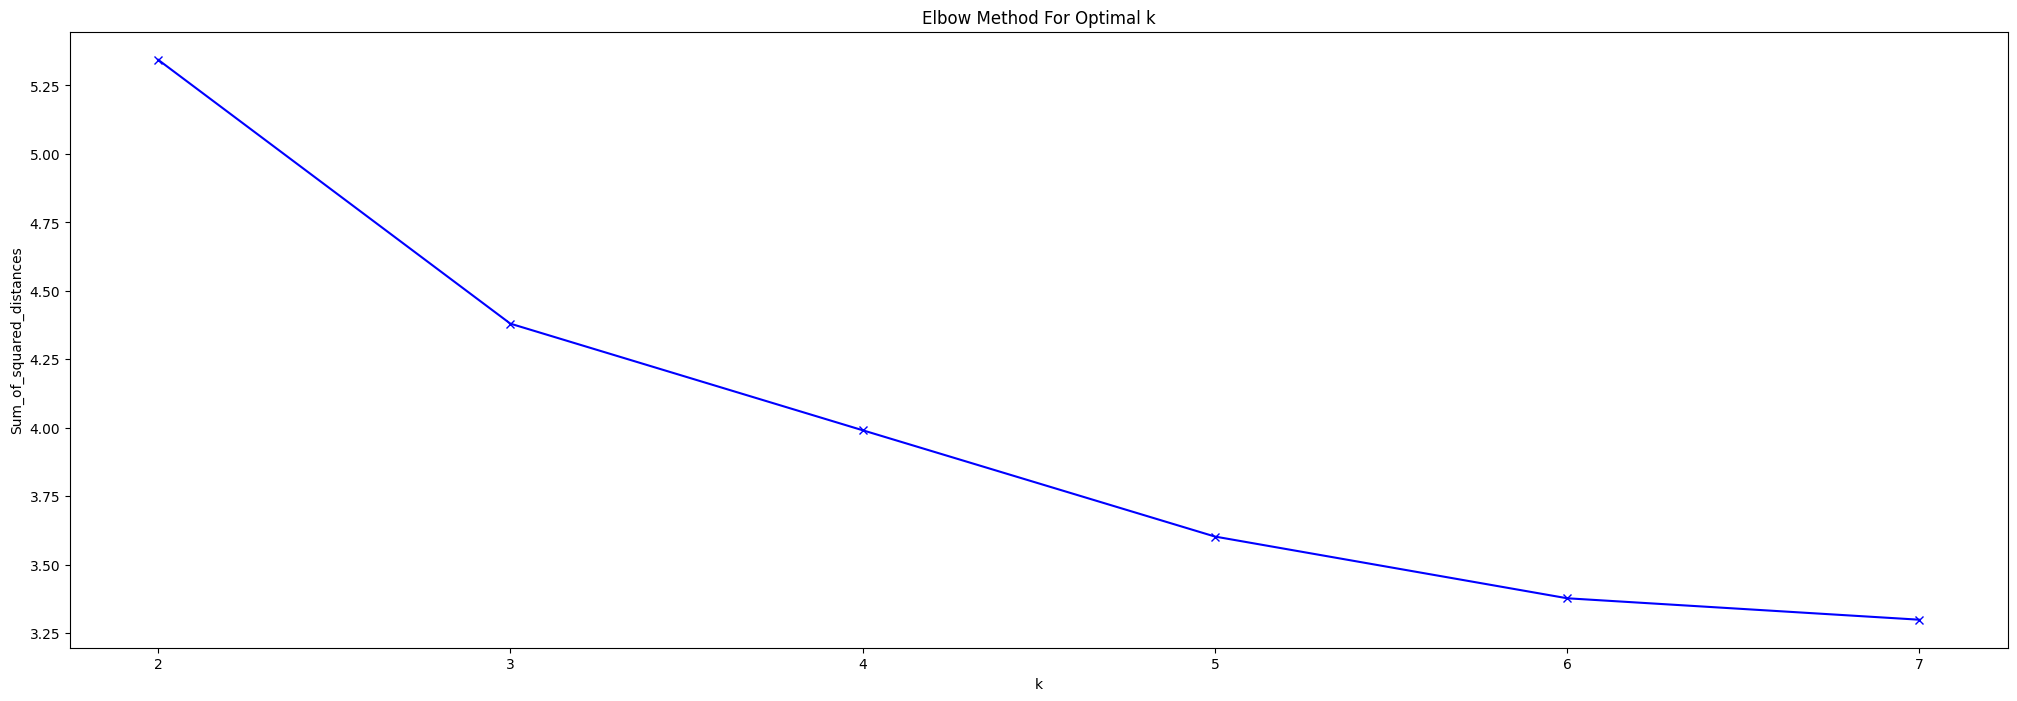

In [59]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Using Sillhoute Method

For n_clusters = 2 The average silhouette_score is : 0.45
For n_clusters = 3 The average silhouette_score is : 0.31
For n_clusters = 4 The average silhouette_score is : 0.19
For n_clusters = 5 The average silhouette_score is : 0.13


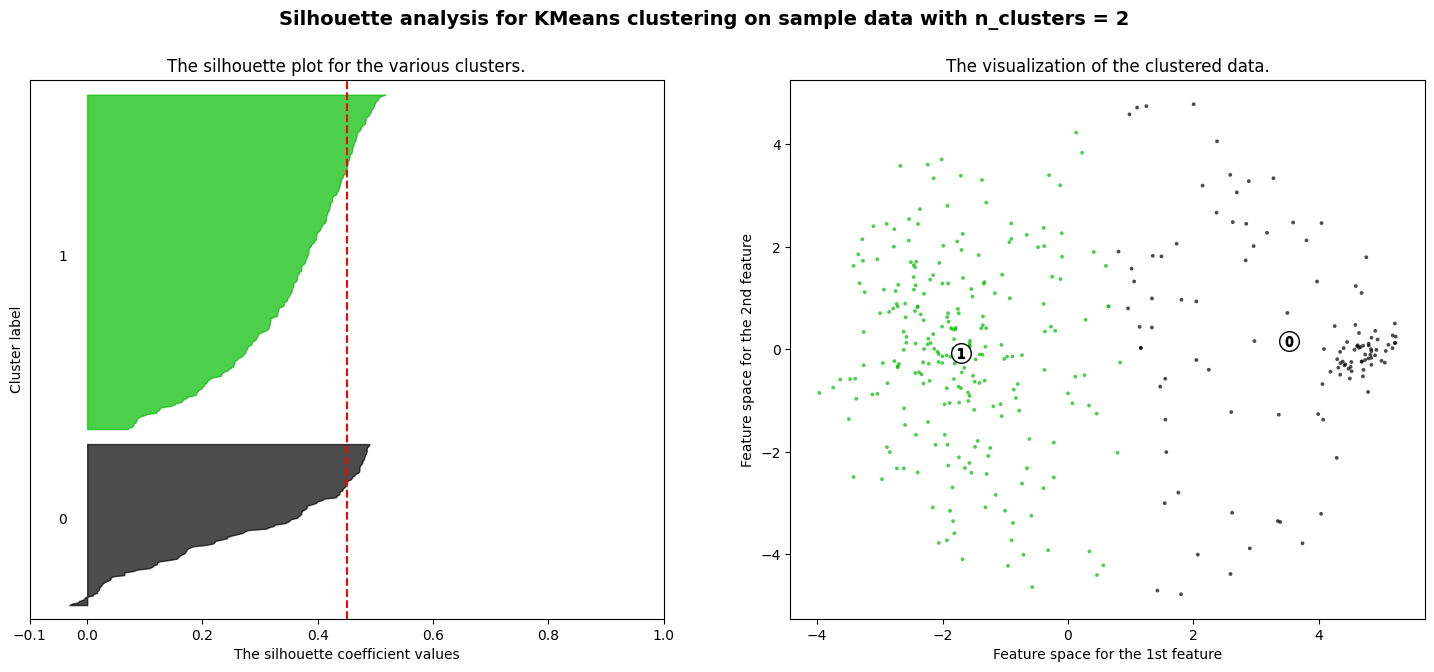

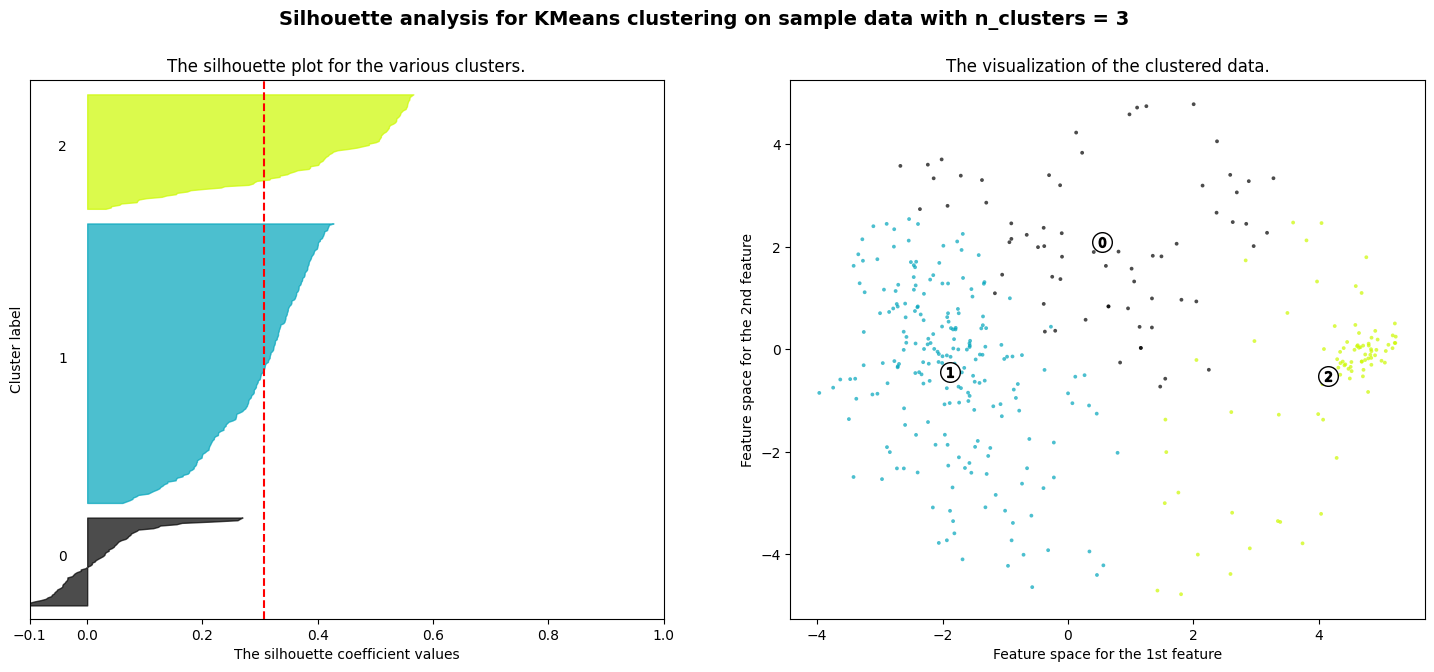

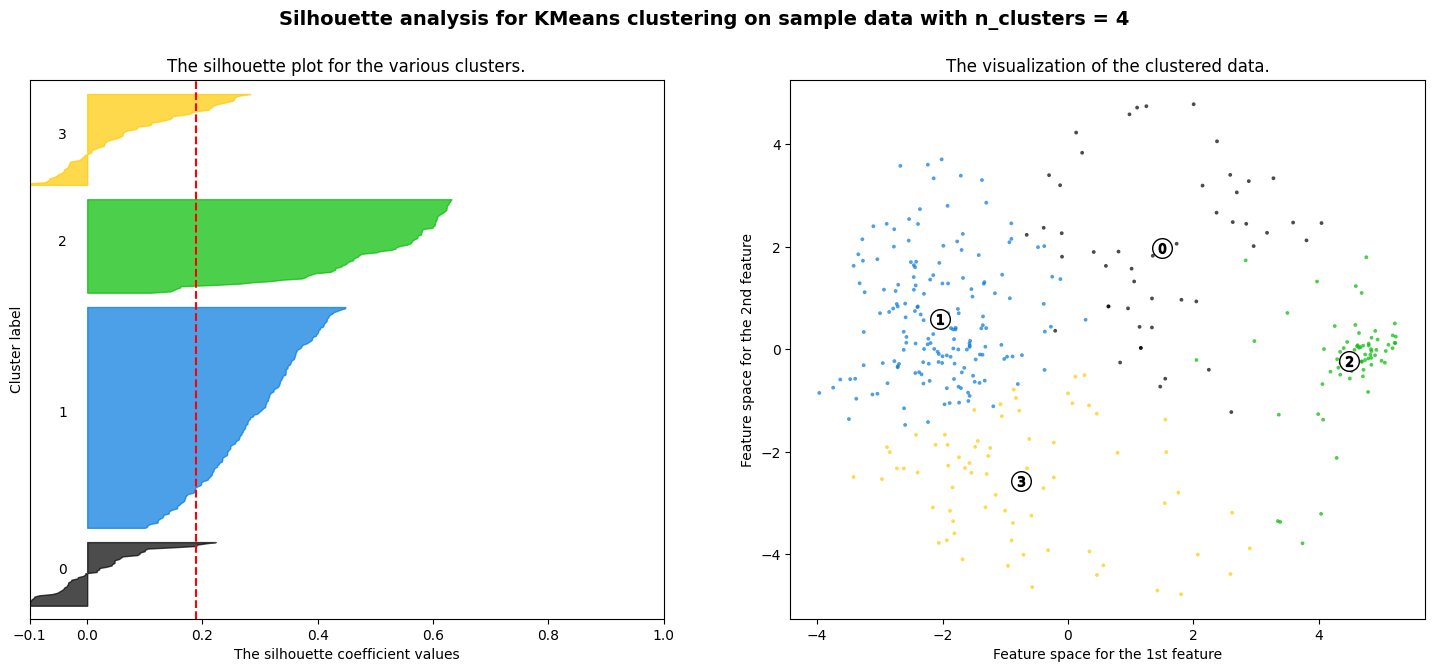

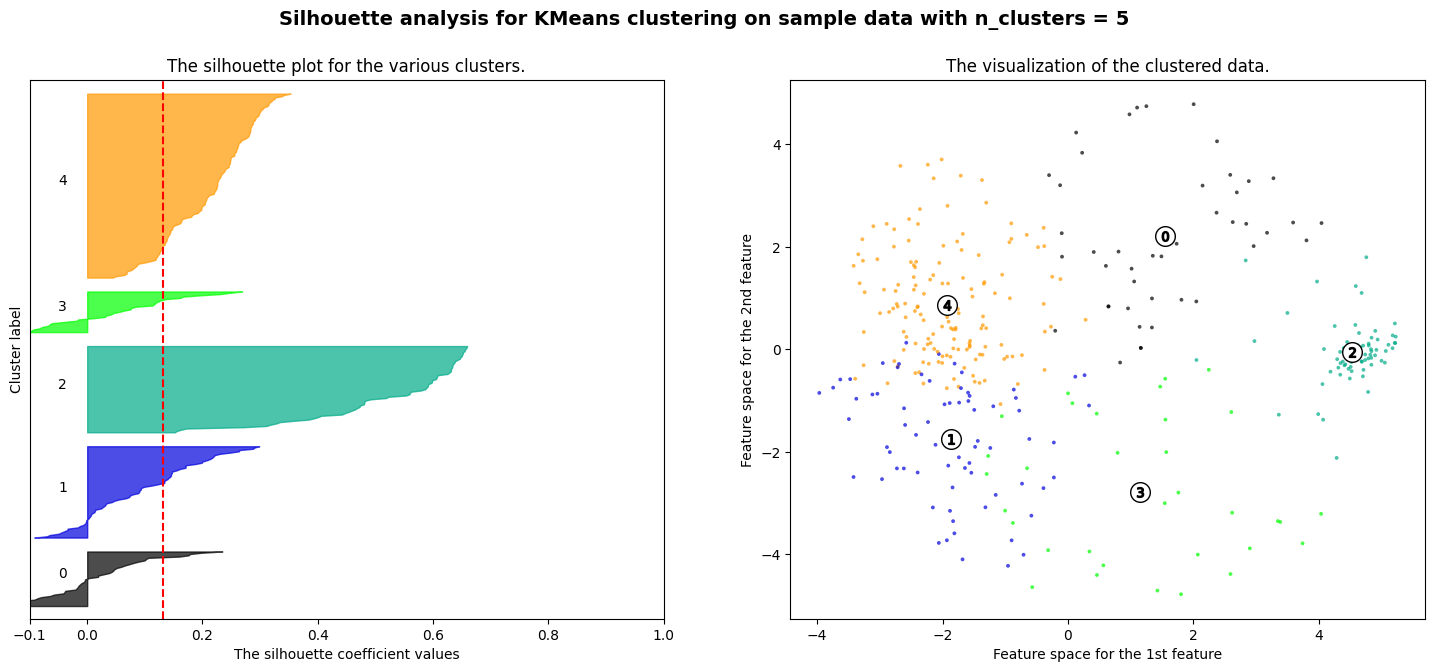

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


train_pca = list(X.reshape(X.shape[0], X.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

X_train_pca = train_pca

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X_train_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()


        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_train_pca[:, 0], X_train_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


## Model Training

Euclidean k-means
Euclidean silhoutte: 0.22


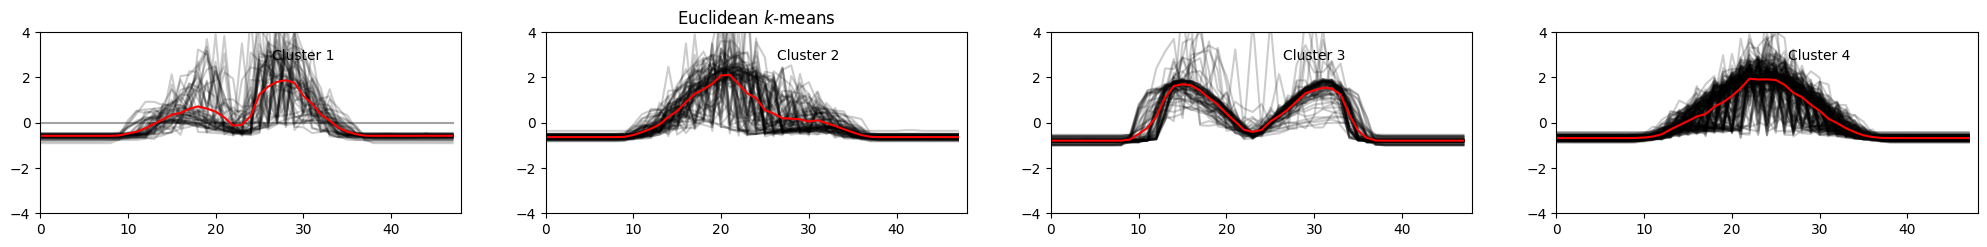

In [63]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")